# 3. Audio Features (6 points):
**Load and analyze the audio features:**

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

**Feature Variance**

(a) Which audio features appear useful? Select only the most relevant ones or perform a down projection
for the next steps.

In [2]:
meta_df = pd.read_csv(r"C:\Users\user\Desktop\MLPC\metadata.csv")
meta_df.set_index("filename",inplace=True)
an_df = pd.read_csv(r"C:\Users\user\Desktop\MLPC\annotations.csv")
an_df.set_index("filename",inplace=True)
an_df["duration"] = an_df["offset"] - an_df["onset"]

In [3]:
import os

audio_features = {}

for idx, row in meta_df.iterrows():
    file_name = idx.replace("mp3", "npz")
    path_to_feature_file = os.path.join(r"C:\Users\user\Desktop\MLPC", "audio_features", file_name)
    
    features = np.load(path_to_feature_file)["embeddings"]
    audio_features[idx] = features
print("Number of feature files:", len(audio_features))

Number of feature files: 9026


In [80]:
feature_names= ["embeddings","melspectrogram","mfcc","mfcc_delta","mfcc_delta2","flatness","centroid","bandwidth","flux","contrast","energy","zerocrossingrate","power"]

In [55]:
# dict keys:feature names values: sample values 
from sklearn.preprocessing import StandardScaler
features= {}
for i in feature_names:
    features[i] = []

for i in feature_names:
    for idx, row in meta_df.iterrows():
        file_name = idx.replace("mp3", "npz")
        path_to_feature_file = os.path.join(r"C:\Users\user\Desktop\MLPC", "audio_features", file_name)
        feature = np.load(path_to_feature_file)[i]
        features[i].append(feature)
    





In [57]:
len(features["power"])

9026

In [60]:
feature_variance = {}
for i in features:
    feature_variance[i] = []

for i in  features.keys():
    all_data = np.concatenate(features[i], axis=0) 
    var_vector = np.var(all_data, axis=0)  
    mean_var=np.mean(var_vector)
    feature_variance[i] = mean_var  
feature_variance

{'embeddings': np.float32(0.16439807),
 'melspectrogram': np.float32(4.104725),
 'mfcc': np.float32(8.133642),
 'mfcc_delta': np.float32(0.037693016),
 'mfcc_delta2': np.float32(0.011817663),
 'flatness': np.float32(0.008108149),
 'centroid': np.float64(911897.7522526988),
 'bandwidth': np.float64(553391.9807078558),
 'flux': np.float32(233.33109),
 'contrast': np.float64(21.883677801343833),
 'energy': np.float32(27580.387),
 'zerocrossingrate': np.float64(0.01563705663770939),
 'power': np.float32(8344511.5)}

In [62]:
def summarize_feature(feature_list, agg_func=np.mean):
    """Summarize each sample in a feature list using agg_func (mean, var, etc.)"""
    return [agg_func(sample) if isinstance(sample, (np.ndarray, list)) else sample
            for sample in feature_list]

# 2. Build a summary DataFrame
summary_dict = {}
for feature_name, sample_list in features.items():
    summary_dict[feature_name] = summarize_feature(sample_list, agg_func=np.mean)  # or np.var, np.median, etc.

df_summary = pd.DataFrame(summary_dict)
corr_matrix = df_summary.corr()

In [63]:
feature_variance["index"]=[0]
feature_variance["index"]
var_df = pd.DataFrame.from_dict(feature_variance)
var_df

,embeddings,melspectrogram,mfcc,mfcc_delta,mfcc_delta2,flatness,centroid,bandwidth,flux,contrast,energy,zerocrossingrate,power,index
0,0.164398,4.104725,8.133642,0.037693,0.011818,0.008108,911897.752253,553391.980708,233.331085,21.883678,27580.386719,0.015637,8344511.5,0


Text(0.5, 1.0, 'variance of single dimesional features')

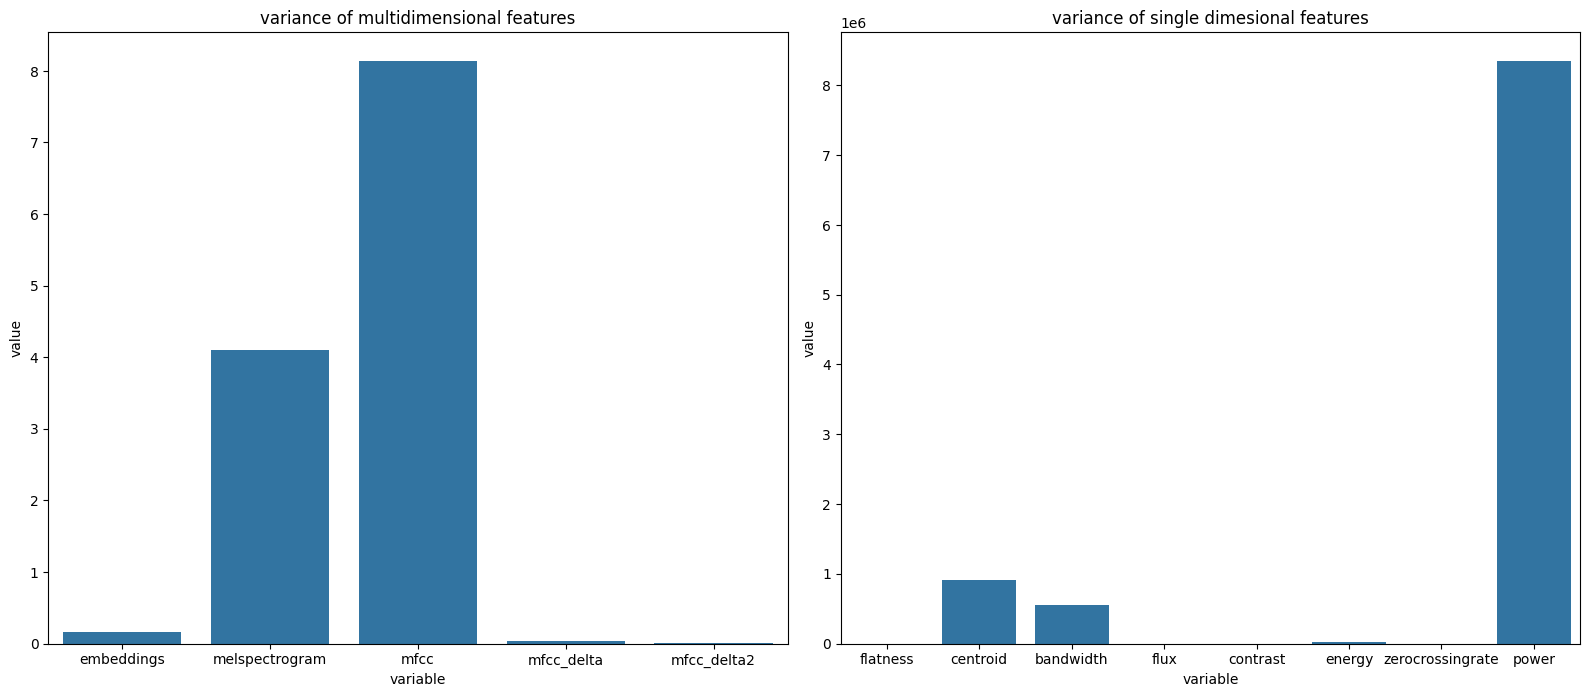

In [76]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
plot_df1 = var_df[["embeddings", "melspectrogram", "mfcc", "mfcc_delta", "mfcc_delta2"]].melt()
plot_df2= var_df[["flatness","centroid","bandwidth","flux","contrast","energy","zerocrossingrate","power"]].melt()
sns.barplot(data=plot_df1,x="variable",y="value",ax=ax[0])
sns.barplot(data=plot_df2,x="variable",y="value",ax=ax[1])
plt.tight_layout()
ax[0].set_title("variance of multidimensional features")
ax[1].set_title("variance of single dimesional features")

<Axes: >

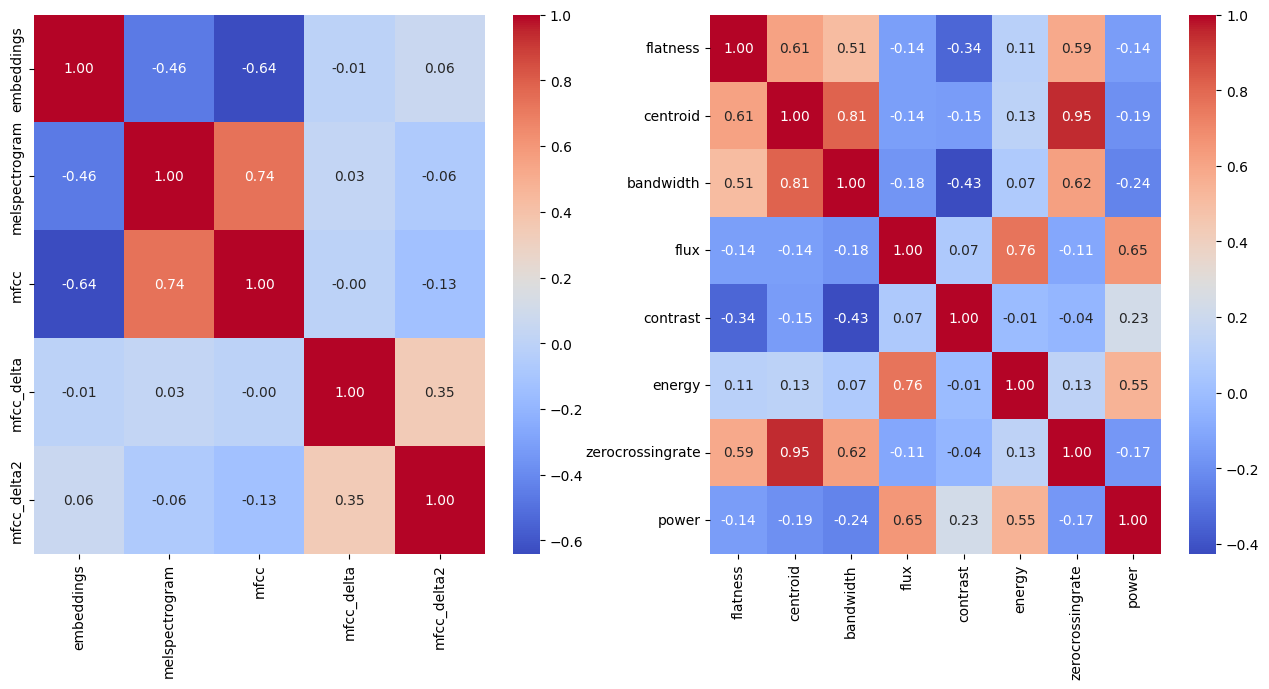

In [79]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
selected= ["embeddings","melspectrogram","mfcc","mfcc_delta","mfcc_delta2"]
s = ["flatness","centroid","bandwidth","flux","contrast","energy","zerocrossingrate","power"]
sns.heatmap(corr_matrix.loc[selected, selected], annot=True, cmap='coolwarm', fmt=".2f",ax=ax[0])
sns.heatmap(corr_matrix.loc[s, s], annot=True, cmap='coolwarm', fmt=".2f",ax=ax[1])

most usefull audio features based on their variance and correlation are:



multidimensional: mfcc & melspectogram are the most informative multidimensionl features according to their variance,however using both of them to train the model makes them redundant feature hence their high corellation.


single dimensional: power & centroid  are the most informative multidimensionl features according to their variance and since they have a low corelation score they capture independent information so they are infact  not redundant

(b) Extract a fixed-length feature vector for each annotated region as well as for all the silent parts in
between. The most straightforward way to do this is to average the audio features of the corresponding
region over time, as shown in the tutorial session.

In [19]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import Counter
from matplotlib import cm

In [20]:
# CONFIGURATION
ANNOTATIONS_CSV = "../annotations.csv"
AUDIO_FEATURE_FOLDER = "../audio_features"
N_CLUSTERS = 20
#HOP_LENGTH = 512
#SR = x # sampling rate
RESOLUTION = 0.120 # mode of temporal resolution of the features is 120 ms

FEATURE_KEYS = {
    "mfcc": "multi",
    "melspectrogram": "multi",
    "power": "single",
    "centroid": "single",
    "bandwidth": "single"
}

In [21]:
# --- Function: Extract averaged features from region ---
def extract_region_features(features_dict, start_idx, end_idx):
    segment_feats = []
    for k, typ in FEATURE_KEYS.items():
        if k not in features_dict:
            continue
        segment = features_dict[k][start_idx:end_idx]
        if segment.shape[0] == 0:
            continue
        if typ == "multi":
            segment_feats.append(np.mean(segment, axis=0))
        else:
            segment_feats.append([np.mean(segment)])
    if segment_feats:
        return np.concatenate(segment_feats)
    return None

# --- Read and check annotations ---
try:
    annotations = pd.read_csv(ANNOTATIONS_CSV)
    print("Annotations loaded successfully.")
except Exception as e:
    print(f"Error loading annotations: {e}")
    exit()

# Verify that 'filename' column exists in annotations DataFrame
if 'filename' not in annotations.columns or 'onset' not in annotations.columns or 'offset' not in annotations.columns:
    print("Missing required columns in annotations: 'filename', 'onset', or 'offset'.")
    exit()

# --- Extract Features for Annotated & Silent Regions ---
region_features = []
region_labels = []

grouped = annotations.groupby("filename")
for filename, group in grouped:
    feature_file = os.path.join(AUDIO_FEATURE_FOLDER, filename.replace(".mp3", ".npz"))
    
    # Check if the feature file exists
    if not os.path.exists(feature_file):
        print(f"Missing features for {filename}")
        continue

    # Load the features from the npz file
    try:
        features = np.load(feature_file)
    except Exception as e:
        print(f"Error loading features for {filename}: {e}")
        continue

    # Ensure required keys are present
    if any(k not in features for k in FEATURE_KEYS):
        print(f"Missing keys in {filename}")
        continue

    total_frames = features[list(FEATURE_KEYS.keys())[0]].shape[0]
    time_regions = []

    # Annotated Regions
    for _, row in group.iterrows():
        onset_idx = int(row['onset'] / RESOLUTION)
        offset_idx = int(row['offset'] / RESOLUTION)
        time_regions.append((onset_idx, offset_idx))

        if offset_idx > onset_idx and offset_idx <= total_frames:
            feat = extract_region_features(features, onset_idx, offset_idx)
            if feat is not None and not np.isnan(feat).any():
                region_features.append(feat)
                region_labels.append("annotated")

    # Silent Regions (gaps between annotations)
    prev_end = 0
    for onset_idx, offset_idx in time_regions:
        if onset_idx > prev_end:
            silent = extract_region_features(features, prev_end, onset_idx)
            if silent is not None and not np.isnan(silent).any():
                region_features.append(silent)
                region_labels.append("silent")
        prev_end = max(prev_end, offset_idx)

    if prev_end < total_frames:
        silent = extract_region_features(features, prev_end, total_frames)
        if silent is not None and not np.isnan(silent).any():
            region_features.append(silent)
            region_labels.append("silent")

# Final check if region_features and region_labels have been populated
if len(region_features) == 0:
    print("No features extracted. Check your annotation data and feature files.")
else:
    print(f"Extracted {len(region_features)} feature vectors.")

Annotations loaded successfully.
Extracted 51949 feature vectors.


In [22]:
# FEATURE CLEANUP
X = np.array([f for f in region_features if f is not None and f.ndim == 1])
labels_array = np.array(region_labels)

mask = ~np.isnan(X).any(axis=1)
X_clean = X[mask]
labels_clean = labels_array[mask]

scaler = StandardScaler().fit(X_clean)
X_scaled = scaler.transform(X_clean)

(c) Cluster the audio features for the extracted regions.

In [23]:
# CLUSTERING
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0)
cluster_ids = kmeans.fit_predict(X_scaled)

Can you identify meaningful clusters of audio
features? Do the feature vectors of the silent regions predominantly fall into one large cluster?

In [24]:
# ANALYZING SILENT CLUSTERS
silent_cluster_ids = [cluster_ids[i] for i, lbl in enumerate(labels_clean) if lbl == "silent"]
silent_counts = Counter(silent_cluster_ids)

print("Silent region cluster distribution:")
for cluster, count in sorted(silent_counts.items()):
    print(f"Cluster {cluster}: {count} silent regions")

Silent region cluster distribution:
Cluster 0: 745 silent regions
Cluster 1: 12 silent regions
Cluster 2: 129 silent regions
Cluster 3: 743 silent regions
Cluster 4: 1918 silent regions
Cluster 5: 458 silent regions
Cluster 6: 404 silent regions
Cluster 7: 368 silent regions
Cluster 8: 590 silent regions
Cluster 9: 1118 silent regions
Cluster 10: 1236 silent regions
Cluster 11: 686 silent regions
Cluster 12: 1051 silent regions
Cluster 13: 150 silent regions
Cluster 14: 1367 silent regions
Cluster 15: 1616 silent regions
Cluster 16: 1147 silent regions
Cluster 17: 1467 silent regions
Cluster 18: 108 silent regions
Cluster 19: 916 silent regions


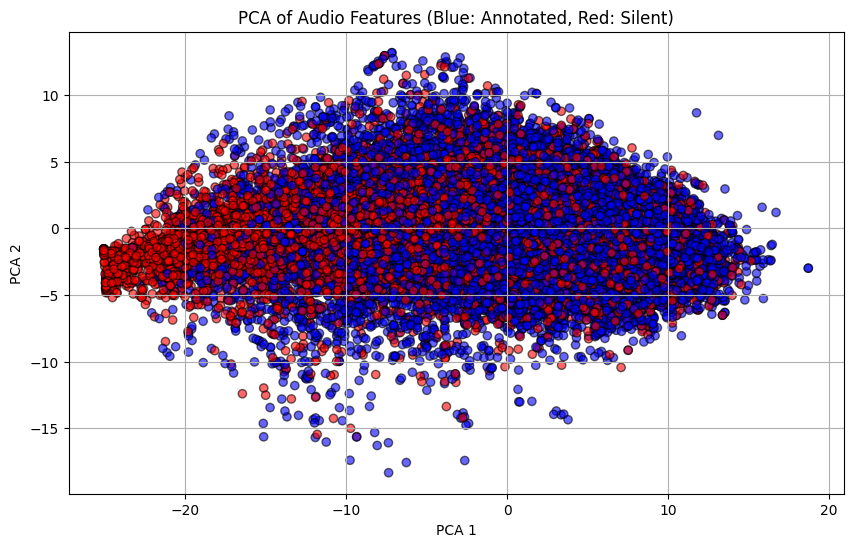

C:\Users\jeron\AppData\Local\Temp\ipykernel_46740\1300229302.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', N_CLUSTERS)


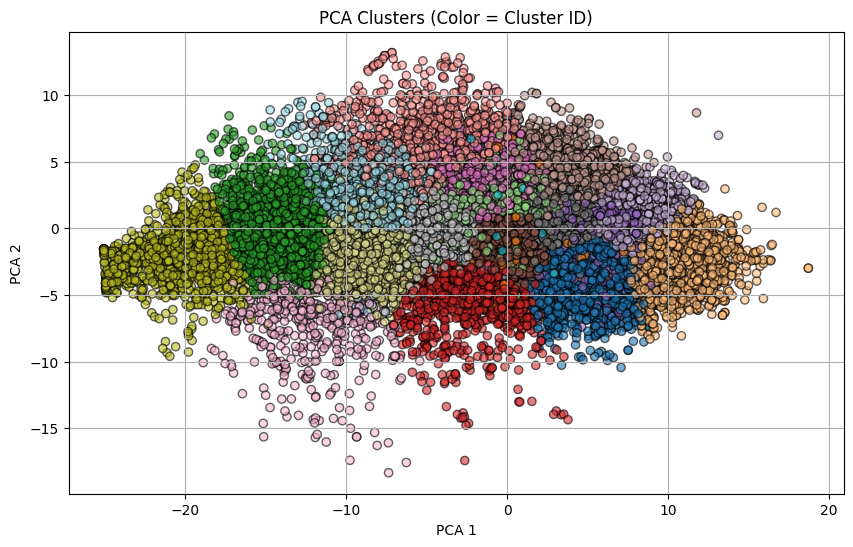

In [25]:
#VISUALIZING PCA CLUSTERS
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_scaled)
colors = ['red' if lbl == 'silent' else 'blue' for lbl in labels_clean]

plt.figure(figsize=(10, 6))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=colors, alpha=0.6, edgecolor='k')
plt.title("PCA of Audio Features (Blue: Annotated, Red: Silent)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

# --- Visualization: Clusters (Color Coded) ---
colormap = cm.get_cmap('tab20', N_CLUSTERS)
cluster_colors = [colormap(c) for c in cluster_ids]

plt.figure(figsize=(10, 6))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=cluster_colors, alpha=0.6, edgecolor='k')
plt.title("PCA Clusters (Color = Cluster ID)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

In [26]:
# still gotta tweak visualisation and (b) a bit more